<div align="center">
    <h1><b>4. Klasterizacija</b></h1>
</div>

---

- Za klasterizaciju će se koristiti K-Means algoritam. Biće upotrebljena dva obilježja: **air_temperature** i **wind_speed**.

<br>

In [11]:
library(ggplot2)
library(dplyr)
library(cluster)
library(arrow)

In [12]:
TRAIN_DATASET_PATH <- "../data/nsrdb_puerto_rico_2017_train.parquet"
TEST_DATASET_PATH <- "../data/nsrdb_puerto_rico_2017_test.parquet"

In [13]:
features <- c("air_temperature", "wind_speed")

set.seed(123)

train_df <- read_parquet(TRAIN_DATASET_PATH) %>% 
  select(all_of(features))

train_scaled <- train_df %>%
  scale() %>% 
  as.data.frame()

<br><br>

<div align="center">
   <h3><b>Izbor optimalnog broja klastera</b></h3>
</div>

---

- Za određivanje optimalnog broja klastera koristiće se *Elbow* metoda.

<br>

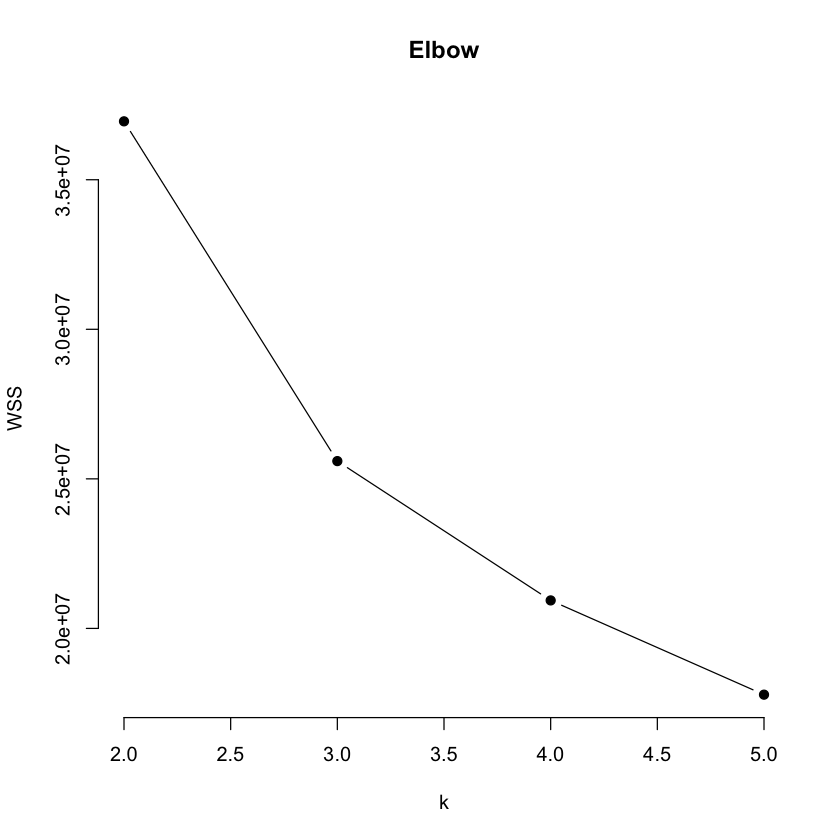

In [ ]:
k_values <- 2:5
wss <- sapply(k_values, function(k) {
  kmeans(train_scaled, centers = k, nstart = 15)$tot.withinss
})

# Plot Elbow
p <- plot(k_values, wss, type = "b", pch = 19, frame = FALSE,
     xlab = "k",
     ylab = "WSS",
     main = "Elbow")
ggsave("elbow_plot.png", plot = p, width = 6, height = 4, dpi = 300)


In [19]:
k_values <- c(2, 3)
results <- list()

In [ ]:

for (k in k_values) {
  
  km_model <- kmeans(train_scaled, centers = k, nstart = 25)
  
  # Add cluster to scaled data for correct plotting
  train_scaled$cluster <- factor(km_model$cluster)
  
  # Convert centers back to original scale properly
  centers_original <- data.frame(
    air_temperature = km_model$centers[, "air_temperature"] * attr(scale(train_df$air_temperature), "scaled:scale") + attr(scale(train_df$air_temperature), "scaled:center"),
    wind_speed = km_model$centers[, "wind_speed"] * attr(scale(train_df$wind_speed), "scaled:scale") + attr(scale(train_df$wind_speed), "scaled:center"),
    cluster = factor(1:k)
  )
  
  cat("\n===========================\n")
  cat("K =", k, "\n")
  cat("Cluster size:\n")
  print(km_model$size)
  
  cat("\nCluster centers (original scale):\n")
  print(centers_original)

  cat("\nCluster Summary:\n")
  # Add cluster to original data for summary
  train_df$cluster <- factor(km_model$cluster)
  print(train_df %>% group_by(cluster) %>% summarise(across(all_of(features), list(mean = mean, sd = sd))))
  cat("===========================\n")
  
  results[[paste0("k_", k)]] <- list(
    model = km_model,
    wss = km_model$tot.withinss,
    size = km_model$size,
    centers = centers_original
  )
  
  # Plot using original data with correct centers
  p <- ggplot(train_df, aes(x = air_temperature, y = wind_speed, color = cluster)) +
    geom_point(alpha = 0.6) +
    geom_point(data = centers_original, 
               aes(x = air_temperature, y = wind_speed, color = cluster),
               size = 5, shape = 4, stroke = 2) +
    labs(title = paste("K-means clustering (k =", k, ")"),
         x = "Air temperature",
         y = "Wind speed") +
    theme_minimal()
  
  ggsave(filename = paste0("kmeans_plot_k", k, ".png"), plot = p, width = 6, height = 4, dpi = 300)
  print(p)

<br><br>

<div align="center">
   <h3><b>Rezultati klasterizacije</b></h3>
</div>

---

- Na osnovu Elbow metode, primjećuje se da je optimalna vrijednost **K = 2**.

- *Tabela 1* prikazuje ispitivanje strukture dobijenih klastera

<br>

<div align = "center">

| K | Velicina klastera              | Centri klastera (air_temperature, wind_speed)    | Air temperature mean | Air temperature SD | Wind speed mean    | Wind speed SD      |
|:-:|:------------------------------:|:------------------------------------------------:|:--------------------:|:------------------:|:------------------:|:------------------:|
| 2 | 9,670,022 ; 17,485,142         | (24.93, 39.32) ; (28.29, 39.32)                  | 24.9 ; 28.29         | 1.31 ;  1.15       | 39.3 ; 39.3        | 15.4 ; 14.9        |
| 3 | 8,719,879 ; 7500757 ; 10935628 | (24.84, 36.43) ; (27.81, 54.88) ; (28.40, 30.95) | 24.8 ; 27.8 ; 28.4.  | 1.34 ; 1.28 ; 1.19 | 36.4 ; 54.9 ; 31.0 | 12.5 ; 12.9 ; 8.93 |

<i> Tabela 1 </i>

</div>



<br><br>

<div align="center">
   <h3><b>Vizualizovanje odnosa između vrijednosti obilježja i pripadnosti klasteru</b></h3>
</div>
---
<br>
<br>

<i> Graf 1 </i> vizualizovanje odnosa između vrijednosti obilježja za **K = 2**

<div align="center">

![Graf 1: Air temperature vs Cluster](../docs/plots/kmeans_plot_k2.png)
<i> Graf 1 </i>

</div>

<br>

<i> Graf 2 </i> vizualizovanje odnosa između vrijednosti obilježja za **K = 2**

<div align="center">

![Graf 2: Air temperature vs Cluster](../docs/plots/kmeans_plot_k3.png)
<i> Graf 2 </i>

</div>

